# Treatment Scheduling

Use the basic TGI models to inform simple rules-of-thumb about treatment sequencing

In [592]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colormaps
from matplotlib.colors import to_rgb

from treatment_sequencing import GrowthInhibitionModel, GillespieTGIModel


In [44]:
def analytic_tumor_values(V0, gamma0, lambda_val, epsilon_val, t):
    # Analytic solution to tumor size and growth rate
    # Assumes lambda_val < gamma0
    
    V = V0 * np.exp(lambda_val * t + (np.exp(-epsilon_val * t) - 1) * (gamma0 / epsilon_val))
    return V

## Sequential Treatments (Ordering Problem)

### Varying Evolution Speed

Let us consider three treatments, with the same initial efficacy but different resistance evolution speeds. Which is the optimal drug ordering? 

For this initial problem, we will switch at the nadir of each drug treatment. Using the lessons from [`base_TGI_model`](base_TGI_model.ipynb), we know this occurs when $\lambda = \gamma(t)$; we may show that this occurs for $t = \frac{1}{\epsilon}ln \left( \frac{\gamma_{0}}{\lambda} \right)$.

In [325]:
def treatment_comparison_plot(t_max, lambda_vals, epsilon_vals, gamma0_vals=[1,1,1], V0_vals=[1,1,1]):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    titles = ['Slow', 'Medium', 'Fast']

    for i, ax in enumerate(axs):
        params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0_vals[i], 'gamma0': gamma0_vals[i]}
        model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
        model.simulate(t_max=t_max)
        model.plot(ax=ax, linewidth=4, label='Drug Response')
        ax.set_ylim([0, 2]); ax.set_xlim(0, t_max)
        ax.set_title(titles[i] + f" Resistance \n $\epsilon$ = {epsilon_vals[i]}")
        
        ax.vlines(ymin=0, ymax=2, x=np.log(gamma0_vals[i]/lambda_vals[i])/epsilon_vals[i],
                  color='gray', linestyle=':', linewidth=4, label='Nadir Time')
      
    axs[0].legend(loc=2)   
    return fig, axs

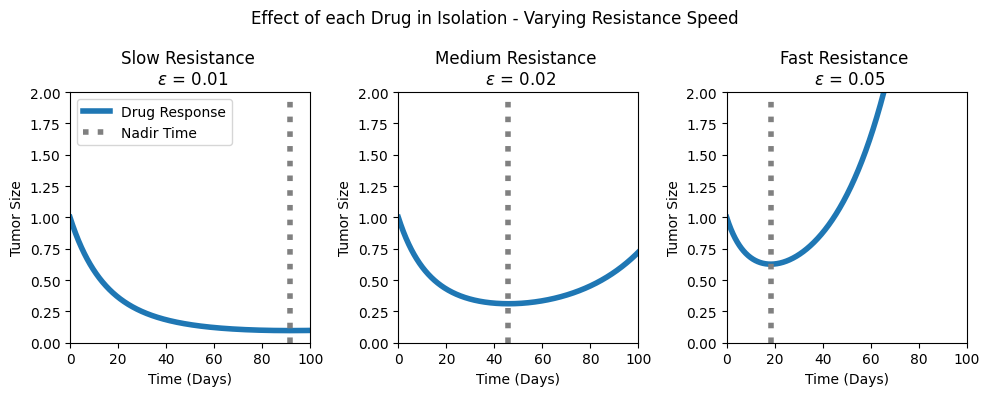

In [326]:
V0 = 1; gamma0 = 0.1; t_max = 100
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.01, 0.02, 0.05]

fig, axs = treatment_comparison_plot(t_max, lambda_vals, epsilon_vals, gamma0_vals=[gamma0]*3)

plt.suptitle("Effect of each Drug in Isolation - Varying Resistance Speed"); plt.tight_layout()

In [327]:
def compare_df(df1, df2):
    percent_change_ttp = 100*(df2.Time.iloc[-1] - df1.Time.iloc[-1])/df1.Time.iloc[-1]
    print(f"Change in TTP: {df2.Time.iloc[-1] - df1.Time.iloc[-1]:.0f} days, or {percent_change_ttp:.1f}%")
    
    print(f"Change in mean tumour size: {100*((df2.V.mean()- df1.V.mean()) / df1.V.mean()):.1f}%")
    print(f"Change in min tumour size: {100*((df2.V.min()- df1.V.min()) / df1.V.min()):.1f}%")
    

In [657]:

def plot_drug_sequence(ax, seq, cols, lambda_vals, epsilon_vals, gamma0_vals=[1,1,1], V0=1, prog_size=1.2 * V0, 
                       drug_duration=None,in_cycle=False, t_offset=0, plot_nadir=False):
    # Plot sequence of each drug, stopping at the minimum tumor size for each treatment type
    
    time = t_offset
    initial_size = V0
    early_prog = False
    switch_drug = False
    
    for i,n in enumerate(seq):  # i is treatment index, n is drug number
        nadir_time = np.log(gamma0_vals[n]/lambda_vals[n])/epsilon_vals[n]
        # print(nadir_time, gamma0_vals[n], lambda_vals[n], epsilon_vals[n])
        if drug_duration is None:
            if nadir_time < 14:
                nadir_time = 14
                switch_drug = True
            end_time = nadir_time
        else:
            end_time = drug_duration[i]
            
        if not in_cycle and i == len(seq)-1:
            end_time *= 20  # Continue to progression at end
            
            
        params = {'lambda': lambda_vals[n], 'epsilon': epsilon_vals[n], 'V0': V0, 'gamma0': gamma0_vals[n]}
        model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)

        model.simulate(t_max=end_time); model.results_df['Time'] += time 
        model.results_df['Drug Index'] = n
        
        if i < len(seq)-1 or in_cycle :  # Not the final treatment
            V0 = model.results_df['V'].iloc[-1]
        # else:  # Curtail final treatment to threshold
        #     model.results_df = model.results_df[model.results_df['V'] < prog_size]
        if model.results_df['V'].iloc[-1] > prog_size:  # Progression
            model.results_df = model.results_df[model.results_df['V'] < prog_size]
            model.results_df['V'].iloc[-1] = prog_size * 1.01
            early_prog = True
        

        model.plot(ax=ax, linewidth=4, color=cols[n], label=('Drug ' + {0:'A', 1:'B', 2:'C'}[n]),
                   apply_tight_layout=False) #, linestyle=['-', '--', ':'][n])
        if plot_nadir:
            ax.vlines(ymin=0, ymax=prog_size, x=time + nadir_time,
                      color=cols[n], alpha=0.5, linestyle=':', linewidth=4)
        time = max(model.results_df['Time'])
        
        if i == 0:
            full_df = model.results_df.copy()
        else:
            full_df = pd.concat([full_df, model.results_df])
            
        if early_prog:
            # print('Warning: Early progression occured')
            break
        
        if switch_drug:
            continue
        
    ax.legend(); ax.set_ylim(0, prog_size); #ax.set_xlim(left=0)
    return full_df

Change in TTP: 65 days, or 23.2%
Change in mean tumour size: 1.0%
Change in min tumour size: 0.0%


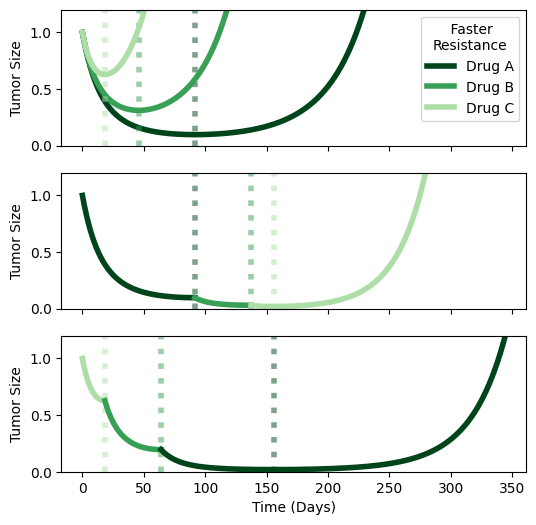

In [488]:

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=[gamma0]*3, prog_size=1.2, plot_nadir=True) 

dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=[gamma0]*3, prog_size=1.2, plot_nadir=True) 
inc_sensitivity_df = plot_drug_sequence(axs[2], [2, 1, 0], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=[gamma0]*3, prog_size=1.2, plot_nadir=True)  
axs[0].get_legend().set_title("    Faster\nResistance"); 
axs[1].get_legend().remove(); axs[2].get_legend().remove()
axs[0].set_xlabel(''); axs[1].set_xlabel(''); 
plt.savefig('images/drug_sensitivity_comparison.png')

compare_df(dec_sensitivity_df, inc_sensitivity_df)

Therefore, we can see there is a significant benefit in scheduling drugs in the order of **increasing sensitivity retention**, so that the '_best_' drugs in this respect are scheduled last - counter-intuitive benefit for the clinic (although many caveats here...)?

### Varying initial efficacy

We may also consider the role of initial efficacy in this context, and the impact of this on the overall time to progression.

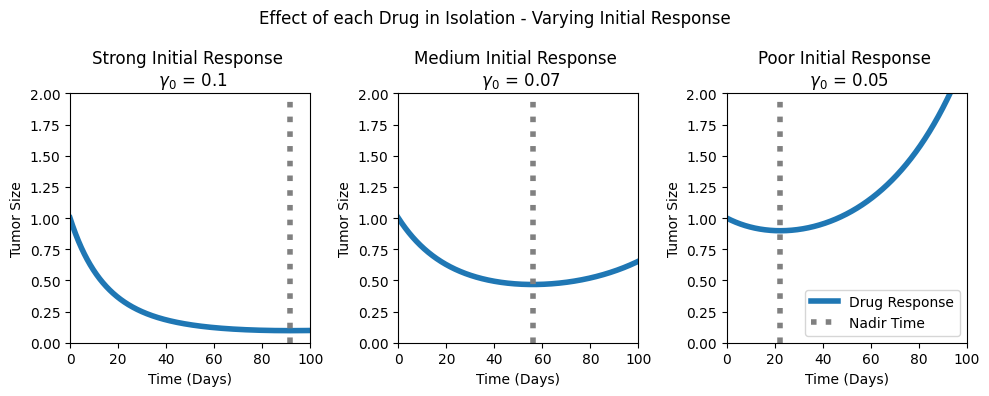

In [330]:
epsilon_vals_ie = [0.01, 0.01, 0.01]
gamma0_vals_ie = [0.1, 0.07, 0.05]

strengths = ['Strong', 'Medium', 'Poor']


fig, axs = treatment_comparison_plot(t_max, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie)
axs[2].legend(loc=4); axs[0].get_legend().remove()

for i, ax in enumerate(axs):
    ax.set_title(strengths[i] + f" Initial Response \n $\gamma_{0}$ = {gamma0_vals_ie[i]}")

plt.suptitle("Effect of each Drug in Isolation - Varying Initial Response"); plt.tight_layout()

Change in TTP: 0 days, or 0.0%
Change in mean tumour size: 48.5%
Change in min tumour size: -0.0%


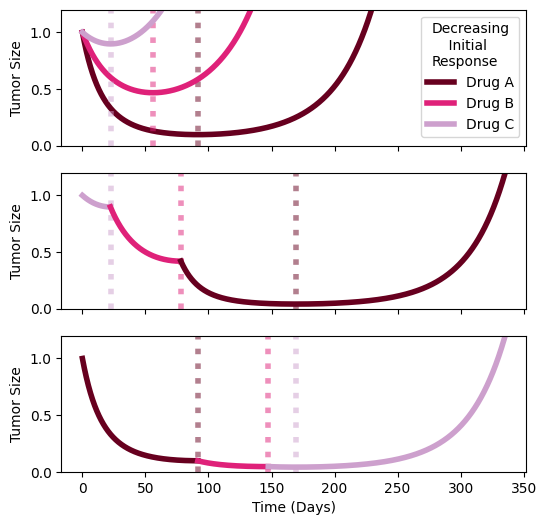

In [489]:
cols_resp = colormaps.get_cmap('PuRd_r')(np.linspace(0, 1, 4))[:-1]

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, sharey=True)
for i, col in enumerate(cols_resp):
    plot_drug_sequence(axs[0], [i], cols_resp, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie, plot_nadir=True) 

inc_resp_df = plot_drug_sequence(axs[2], [0, 1, 2], cols_resp, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie, plot_nadir=True)  
dec_resp_df = plot_drug_sequence(axs[1], [2, 1, 0], cols_resp, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie, plot_nadir=True)  
axs[0].get_legend().set_title("Decreasing\n    Initial\nResponse"); 
axs[1].get_legend().remove(); axs[2].get_legend().remove()
axs[0].set_xlabel(''); axs[1].set_xlabel(''); 
plt.savefig('images/drug_response_comparision.png')

compare_df(inc_resp_df , dec_resp_df)

We can see that changing the sequence of drugs with different initial efficacies does not impact the overall time to progression. However, it does reduce the mean tumor burden over time, reducing the impact on the patient, and so the most efficient drugs should be scheduled first.

_(Note nadir of last treatment, at which point the drug is doing very little and could be removed to minimise toxicity without affecting ttp)_

Clinician should balance tumor burden (which the above schedule minimises) vs toxicity (from spending more time on more aggresive drugs), which the below schedule minimises.
We hope these broad scheduling principles can inform decision-making for clinicans, who are able to weigh up the relative importance of TTP and mean tumor burden on a case-by-case basis.

## Cycling treatments (Timing Problem)

Given this order, how may we then consider cycling treatments - how long should we keep each treatment on for. Start by switching at each nadir, but if we switch earlier (when response rate has dropped by a given factor) then is this beneficial? Each drug's sensitivity increases at a constant rate off treatment, all off treatment

### Drug Resensitisation

Given drug sensitivity decays as $\frac{d\gamma}{dt} = -\epsilon \gamma$ on treatment, it is natural that resensitisation would also occur exponentially. However we choose not to let the rate of this be equal to $\epsilon$, rather a new parameter $\mu$. While this could be set to $\epsilon$, there is no indication that this parameter should vary between drugs, and so as a proof of concept we set $\mu$ to be a constant for all drugs.

Therefore the drug resensitisation should take the form $\gamma(t) = \gamma_{0}(1-e^{-\mu(t-\tau)})$ off treatment, where $t$ is the time elapsed since treatment, and $\tau$ is some offset to account for the partial loss of sensitivity (otherwise the curve begins with $\gamma(t=0) = 0$). We then solve for $\tau$ such that $\gamma(t=0)$ is equal to the final sensitivity of the drug. 

In [530]:
def calc_drug_resensitisation(gamma_vals, times, gamma0_vals, resensitisation_rates=[1,1,1]):
    # Exponential resensitisation of drug response - as described in notes above
    # Can pass resensitisation_rates = epsilon_vals to match rate of evolution
    
    new_gamma_values = []
    
    for i, gamma in enumerate(gamma_vals):
        tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
        val = gamma0_vals[i] * (1 - np.exp(-times[i] * resensitisation_rates[i] - tau))
        new_gamma_values.append(val)
    return new_gamma_values

In [531]:

def calc_drug_resensitisation_alt(gamma_vals, times, gamma0_vals, resensitisation_rates=[1,1,1], n=2):
    # Alternate resensitisation model - power law s.t. y(t) = y0 + (y0 - y1) * (1 - t/T)^n
    
    new_gamma_values = []
    
    for i, gamma in enumerate(gamma_vals):
        # Convert time to consider resensitisation from zero (accounting for current sensitivity)
        # times[i] += np.log(gamma0_vals[i]/gamma) / epsilon_vals[i] 
        times[i] += np.power(gamma/gamma0_vals[i], 1 / n) / resensitisation_rates[i]
        
        if times[i] > 1 / resensitisation_rates[i]:
            val = gamma0_vals[i]  # Fully resensitised
        else:
            val = gamma0_vals[i] * (times[i] * resensitisation_rates[i]) ** n
        
        new_gamma_values.append(val)
    # print(gamma_vals, new_gamma_values)
    return new_gamma_values

In [532]:

def plot_treatment_cycle(ax, drug_duration, seq, cols, lambda_vals, epsilon_vals,
                         gamma0_vals=[1,1,1], resensitisation_rates=[1,1,1], 
                         V0=1, prog_thresh=1.2, elim_thresh=1e-3, n=None):
    # Switch to next treatment when tumor size reaches switch_threshold
    # Stop treatment when tumor size reaches 2x initial size
    
    curr_V = V0; time = 0
    curr_gamma_vals = gamma0_vals
    
    while curr_V < V0 * prog_thresh and curr_V > elim_thresh:
        cycle_df = plot_drug_sequence(ax, seq, cols, lambda_vals, epsilon_vals, 
                                      gamma0_vals=curr_gamma_vals, V0=curr_V, prog_size=prog_thresh*V0,
                                      drug_duration=drug_duration, in_cycle=True, t_offset=time)
        
        # Find time each drug was not being delivered for
        # recovery_times = [sum(drug_duration) - drug_duration[n] for n in seq]  # For multiple drugs
        dt = cycle_df['Time'].iloc[1] - cycle_df['Time'].iloc[0]
        recovery_times = [len(cycle_df[cycle_df['Drug Index'] != n]['Time']) * dt for n in seq]
        
        # Update time, V0 and gamma0_vals
        curr_V = cycle_df['V'].iloc[-1]
        time = cycle_df['Time'].iloc[-1]
        
        active_times = [len(cycle_df[cycle_df['Drug Index'] == n]['Time']) * dt for n in seq]
        depleted_gamma_vals = [curr_gamma_vals[n] * np.exp(-epsilon_vals[n] * active_times[n]) for n in seq]
    
        # print(f"Depleted:{depleted_gamma_vals}, original: {curr_gamma_vals}, start: {gamma0_vals}")
        if n is None:
            curr_gamma_vals = calc_drug_resensitisation(depleted_gamma_vals, recovery_times,
                                                        gamma0_vals, resensitisation_rates)
        else:
            curr_gamma_vals = calc_drug_resensitisation_alt(depleted_gamma_vals, recovery_times,
                                                        gamma0_vals, resensitisation_rates, n=n)
            
        # Save cycle results    
        try:
            full_df = pd.concat([full_df, cycle_df])
        except UnboundLocalError:  # First cycle - full_df not yet defined
            full_df = cycle_df.copy()
        
    # print(full_df.V.iloc[-1], prog_thresh, V0)
    full_df = full_df[full_df['V'] < prog_thresh * V0]  
    return full_df
 

Change in TTP: 2492 days, or 308.5%
Change in mean tumour size: 225.2%
Change in min tumour size: 17.1%


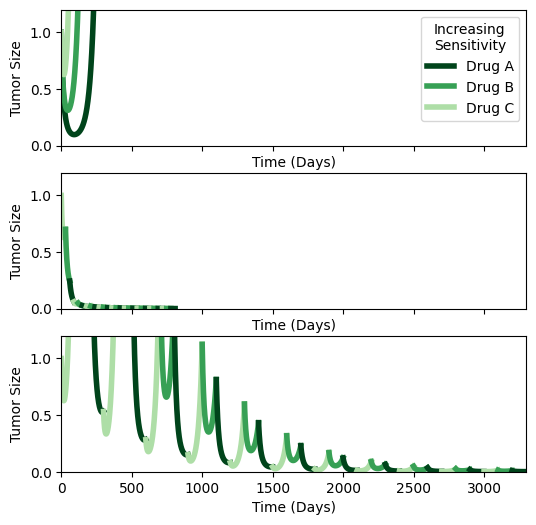

In [391]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=[0.1]*3, prog_thresh=2) 

    
weekly_df = plot_treatment_cycle(ax=axs[1], drug_duration=[30]*3, seq=[2,1,0], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[0.005]*3, n=1/2)
monthly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[100]*3, seq=[2,1,0],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=[0.1]*3,
                                   resensitisation_rates=[0.005]*3, n=1/2) 
axs[0].get_legend().set_title("Increasing\nSensitivity"); 
axs[1].get_legend().remove(); axs[2].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)

compare_df(weekly_df, monthly_df)
# plt.savefig('images/exp_high_resensitisation.png')

<Figure size 600x400 with 0 Axes>

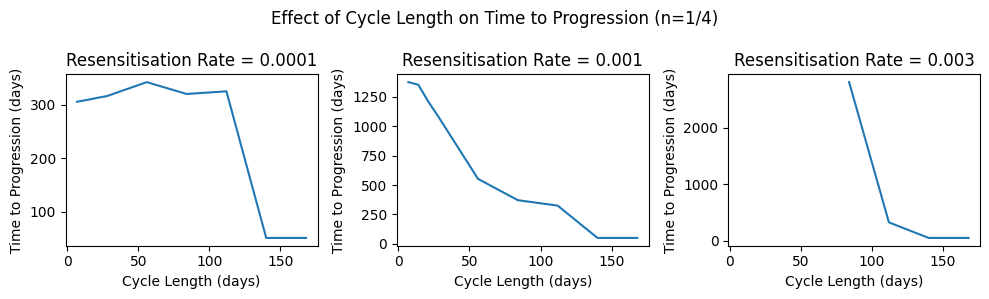

In [271]:
# Vary the treatment duration, and plot this against ttp

fig_null, ax_null = plt.subplots(1, 1, figsize=(6, 4))
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

cycle_lengths = [7, 14, 21, 28, 56, 84, 112, 140, 168]
resensitisation_rates = [0.0001, 0.001, 0.003]


def simulate_cycle_ttp(cycle_length, resensitisation_rate=0.001):
    df = plot_treatment_cycle(ax=ax_null, drug_duration=[cycle_length]*3, seq=[2,1,0], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[resensitisation_rate]*3, n=1/4)
    if df.V.iloc[-1] < df.V.iloc[1]:
        return np.nan  # No progression
    return df.Time.iloc[-1]

for i, rate in enumerate(resensitisation_rates):
    ttps = [simulate_cycle_ttp(cycle_length, rate) for cycle_length in cycle_lengths]
    axs[i].plot(cycle_lengths, ttps, label=f"Resensitisation Rate = {rate}")
    
    axs[i].set_xlabel("Cycle Length (days)"); axs[i].set_ylabel("Time to Progression (days)")
    axs[i].set_title(f"Resensitisation Rate = {rate}")
    
fig_null.clear()
plt.suptitle("Effect of Cycle Length on Time to Progression (n=1/4)")
plt.tight_layout()
plt.savefig('images/cycle_length_ttp_quarterb.png')


    

<Figure size 600x400 with 0 Axes>

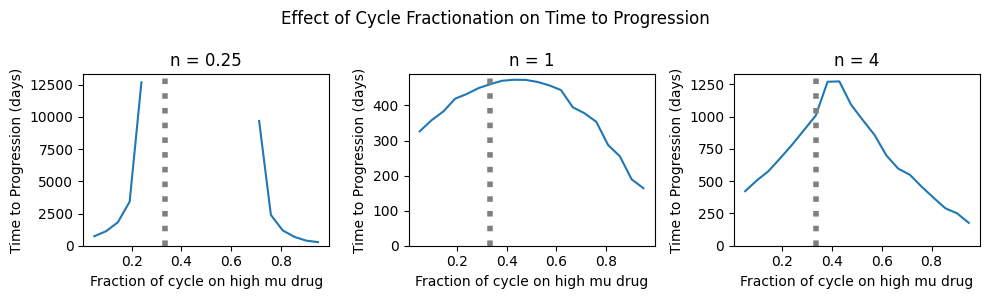

In [290]:
# So how should we optimally schedule drugs with different resensitation rates?
# Consider two drugs with low mu and one with high mu - how should we incorporate the high mu drug?
# For a fixed period (i.e. 100 days), what fraction of the time should we spend on high mu - sweep and optimise

# Vary the treatment duration, and plot this against ttp

fig_null, ax_null = plt.subplots(1, 1, figsize=(6, 4))
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

cycle_frac_values = np.linspace(0.05, 0.95, 20)
n_values = [1/4, 1, 4]


def simulate_fractionated_cycle_ttp(cycle_frac, cycle_length, n_value=1):
    low_mu_frac = (1 - cycle_frac) / 2
    drug_durations = [low_mu_frac * cycle_length, low_mu_frac * cycle_length, cycle_frac * cycle_length]
    df = plot_treatment_cycle(ax=ax_null, drug_duration=drug_durations, seq=[2,1,0], 
                                 cols=cols_sens, lambda_vals=[0.04]*3,
                                 epsilon_vals=[0.02]*3, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[0.002, 0.002, 0.0005], n=n_value)
    if df.V.iloc[-1] < df.V.iloc[1]:
        return np.nan  # No progression
    return df.Time.iloc[-1]

for i, n in enumerate(n_values):
    ttps = [simulate_fractionated_cycle_ttp(cycle_frac, cycle_length=100, n_value=n) for cycle_frac in cycle_frac_values]
    axs[i].plot(cycle_frac_values, ttps, label=f"Resensitisation Rate = {rate}")
    
    axs[i].set_xlabel("Fraction of cycle on high mu drug"); axs[i].set_ylabel("Time to Progression (days)")
    axs[i].set_title(f"n = {n}"); axs[i].set_ylim(bottom=0)
    axs[i].vlines(ymin=0, ymax=axs[i].get_ylim()[1], x=1/3, color='gray', linestyle=':', linewidth=4)
    
fig_null.clear()
plt.suptitle("Effect of Cycle Fractionation on Time to Progression")
plt.tight_layout()
plt.savefig('images/optimal_treatment_fractions_varyn.png')

/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_61158/2452562660.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_61158/2452562660.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_61158/2452562660.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_61158/2452562660.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_61158/2452562660.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  tau = np.log(gamma0_vals[i]/(gamma0_vals[i] - gamma))
/var/folde

<Figure size 600x400 with 0 Axes>

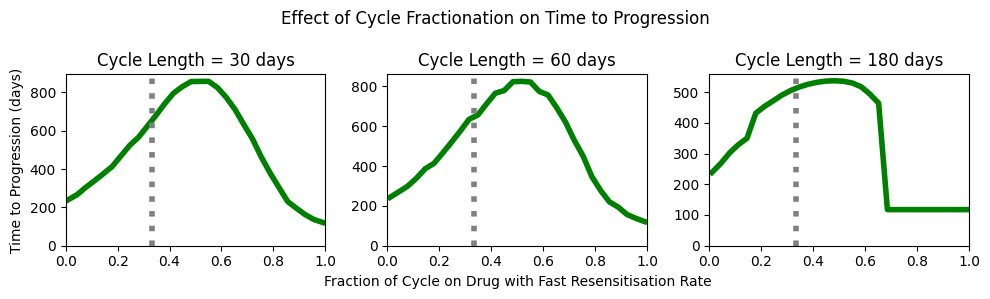

In [470]:
# So how should we optimally schedule drugs with different resensitation rates?
# Consider two drugs with low mu and one with high mu - how should we incorporate the high mu drug?
# For a fixed period (i.e. 100 days), what fraction of the time should we spend on high mu - sweep and optimise

# Vary the treatment duration, and plot this against ttp

fig_null, ax_null = plt.subplots(1, 1, figsize=(6, 4))
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

cycle_frac_values = np.linspace(0.01, 0.99, 30)
cycle_lengths = [30, 60, 180]

def simulate_fractionated_cycle_ttp(cycle_frac, cycle_length, n_value=1):
    low_mu_frac = (1 - cycle_frac) / 2
    drug_durations = [cycle_frac * cycle_length, low_mu_frac * cycle_length, low_mu_frac * cycle_length]
    df = plot_treatment_cycle(ax=ax_null, drug_duration=drug_durations, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=[0.04]*3,
                                 epsilon_vals=[0.02]*3, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[0.02, 0.0005, 0.0005], n=n_value)
    if df.V.iloc[-1] < df.V.iloc[1]:
        return np.nan  # No progression
    return df.Time.iloc[-1]

for i, cycle_length in enumerate(cycle_lengths):
    ttps = [simulate_fractionated_cycle_ttp(cycle_frac, cycle_length=cycle_length, n_value=None) for cycle_frac in cycle_frac_values]
    axs[i].plot(cycle_frac_values, ttps, label=f"Resensitisation Rate = {rate}", linewidth=4, color='g')
    
    axs[i].set_title(f"Cycle Length = {cycle_length} days"); axs[i].set_ylim(bottom=0); axs[i].set_xlim(0, 1)
    axs[i].vlines(ymin=0, ymax=axs[i].get_ylim()[1], x=1/3, color='gray', linestyle=':', linewidth=4)

axs[1].set_xlabel("Fraction of Cycle on Drug with Fast Resensitisation Rate"); axs[0].set_ylabel("Time to Progression (days)")    
fig_null.clear()
plt.suptitle("Effect of Cycle Fractionation on Time to Progression")
plt.tight_layout()
plt.savefig('images/optimal_treatment_fractions_cycle_length.png')
    

In [466]:
def simulate_fractionated_cycle_ttp(cycle_frac, cycle_length, n_value=1):
    low_mu_frac = (1 - cycle_frac) / 2
    drug_durations = [cycle_frac * cycle_length, low_mu_frac * cycle_length, low_mu_frac * cycle_length]
    df = plot_treatment_cycle(ax=ax_null, drug_duration=drug_durations, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=[0.04]*3,
                                 epsilon_vals=[0.02]*3, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[0.02, 0.0005, 0.0005], n=n_value)
    if df.V.iloc[-1] < df.V.iloc[1]:
        return np.nan  # No progression
    return df.Time.iloc[-1]


<Figure size 600x400 with 0 Axes>

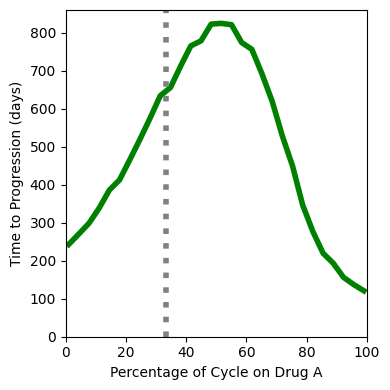

In [483]:
# So how should we optimally schedule drugs with different resensitation rates?
# Consider two drugs with low mu and one with high mu - how should we incorporate the high mu drug?
# For a fixed period (i.e. 100 days), what fraction of the time should we spend on high mu - sweep and optimise

# Vary the treatment duration, and plot this against ttp

def simulate_fractionated_cycle_ttp(cycle_frac, cycle_length, n_value=1):
    low_mu_frac = (1 - cycle_frac) / 2
    drug_durations = [cycle_frac * cycle_length, low_mu_frac * cycle_length, low_mu_frac * cycle_length]
    df = plot_treatment_cycle(ax=ax_null, drug_duration=drug_durations, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=[0.04]*3,
                                 epsilon_vals=[0.02]*3, gamma0_vals=[0.1]*3,
                                 resensitisation_rates=[0.02, 0.0005, 0.0005], n=n_value)
    if df.V.iloc[-1] < df.V.iloc[1]:
        return np.nan  # No progression
    return df.Time.iloc[-1]

fig_null, ax_null = plt.subplots(1, 1, figsize=(6, 4))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

cycle_frac_values = np.linspace(0.01, 0.99, 30)


ttps = [simulate_fractionated_cycle_ttp(cycle_frac, cycle_length=60, n_value=None) for cycle_frac in cycle_frac_values]
ax.plot(cycle_frac_values*100, ttps, label=f"Progression Time", linewidth=4, color='g')

ax.set_ylim(bottom=0); ax.set_xlim(0, 100)
ax.vlines(ymin=0, ymax=ax.get_ylim()[1], x=100/3, color='gray', linestyle=':', linewidth=4)

ax.set_xlabel("Percentage of Cycle on Drug A"); ax.set_ylabel("Time to Progression (days)")    
fig_null.clear()
# plt.suptitle("Effect of Cycle Fractionation on Time to Progression")
plt.tight_layout()
plt.savefig('images/optimal_treatment_fraction.pdf')
    


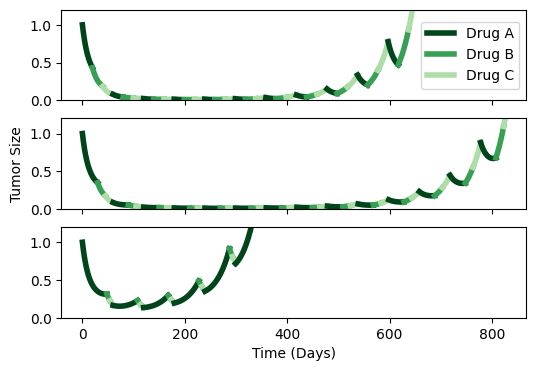

In [469]:
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

cycle_length=60
cycle_fractions = [0.33, 0.5, 0.8]


for i, cycle_frac in enumerate(cycle_fractions):
    low_mu_frac = (1 - cycle_frac) / 2
    drug_durations = [cycle_frac * cycle_length, low_mu_frac * cycle_length, low_mu_frac * cycle_length]
        
    df = plot_treatment_cycle(ax=axs[i], drug_duration=drug_durations, seq=[0,1,2], 
                                    cols=cols_sens, lambda_vals=[0.04]*3,
                                    epsilon_vals=[0.02]*3, gamma0_vals=[0.1]*3,
                                    resensitisation_rates=[0.02, 0.0005, 0.0005], n=None)


axs[0].legend(['Drug A', 'Drug B', 'Drug C'], loc=5)  
axs[1].get_legend().remove(); axs[2].get_legend().remove()
# axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''), axs[1].set_xlabel('')
axs[0].set_ylabel(''), axs[1].set_ylabel('Tumor Size'), axs[2].set_ylabel('')


plt.savefig('images/treatment_fractionation_comparison.pdf')

### Switch at Nadir

Clearly we should adapt the switch time to account for the properties of the drug in question. One natural way to do this is to switch at the nadir of each drug.

Change in TTP: -2 days, or -0.5%
Change in mean tumour size: -20.5%
Change in min tumour size: -54.4%


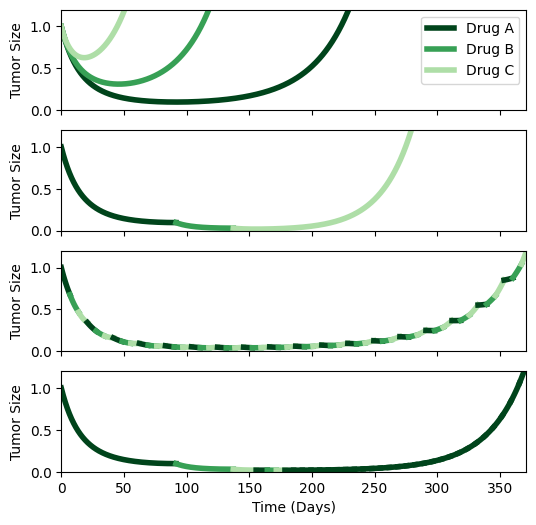

In [562]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.01, 0.02, 0.05]
gamma0_vals = [0.1, 0.1, 0.1]
resensitisation_rates = [0.001, 0.001, 0.001]


fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[7,7,7], seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


Change in TTP: 4 days, or 2.4%
Change in mean tumour size: -11.1%
Change in min tumour size: -28.4%


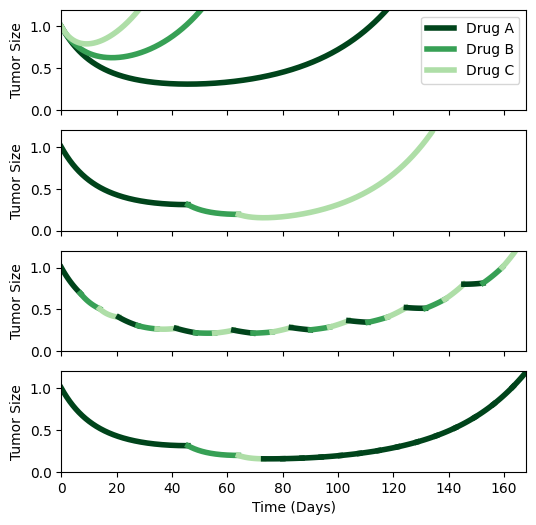

In [561]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.02, 0.05, 0.1]
gamma0_vals = [0.1, 0.1, 0.1]
resensitisation_rates = [0.001, 0.001, 0.001]


fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[7,7,7], seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


Change in TTP: 18 days, or 10.0%
Change in mean tumour size: -35.6%
Change in min tumour size: -39.3%


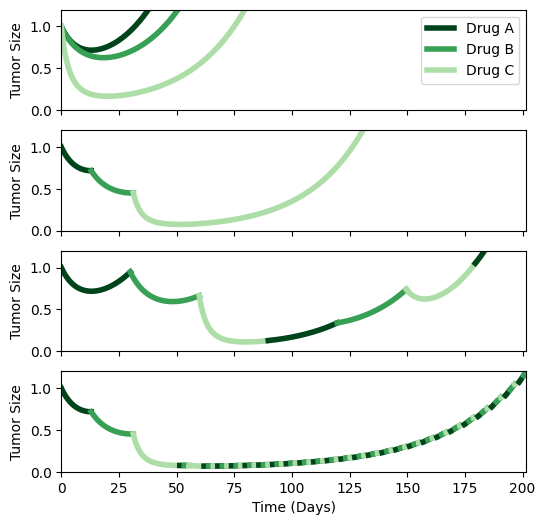

In [579]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.07, 0.05, 0.1]
gamma0_vals = [0.1, 0.1, 0.3]
resensitisation_rates = [0.001, 0.001, 0.005]


fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[30]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


In [590]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

Change in TTP: 18 days, or 7.4%
Change in mean tumour size: -30.2%
Change in min tumour size: -31.1%


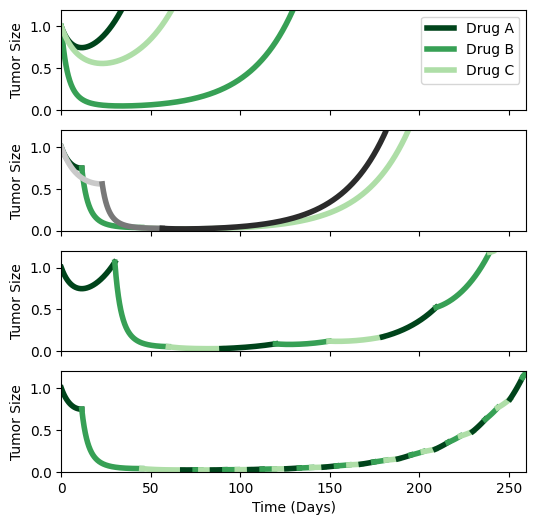

In [599]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.08, 0.06, 0.04]
gamma0_vals = [0.1, 0.3, 0.1]
resensitisation_rates = [0.001, 0.001, 0.005]


fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

bw_cols = [convert_to_rgb_grayscale(col) for col in cols_sens]
dec_sensitivity_df = plot_drug_sequence(axs[1], [2, 1, 0], bw_cols, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[30]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.pdf')


Change in TTP: 29 days, or 14.5%
Change in mean tumour size: -35.6%
Change in min tumour size: -32.3%


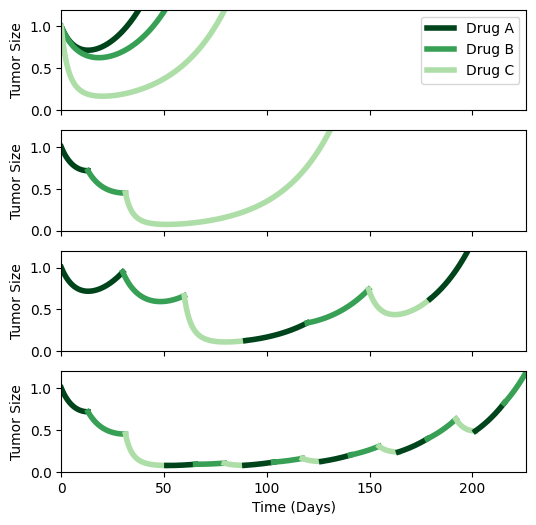

In [608]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.07, 0.05, 0.1]
gamma0_vals = [0.1, 0.1, 0.3]
resensitisation_rates = [0.001, 0.001, 0.01]



fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[30]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


Change in TTP: 599 days, or 144.2%
Change in mean tumour size: -92.4%
Change in min tumour size: -98.4%


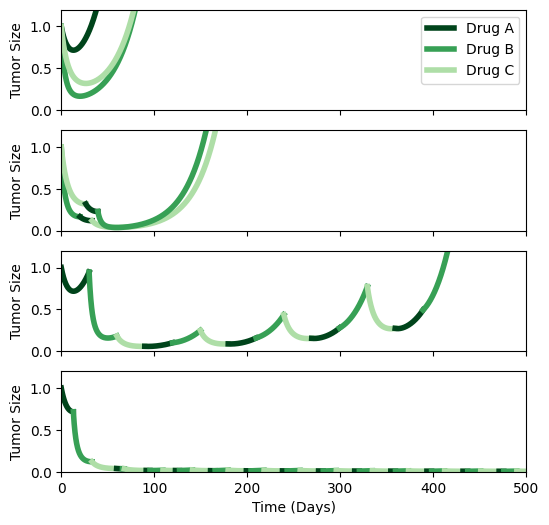

In [645]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.07, 0.1, 0.05]
gamma0_vals = [0.1, 0.3, 0.15]
resensitisation_rates = [0.01, 0.001, 0.05]


fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [1, 0, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)
dec_sensitivity_df = plot_drug_sequence(axs[1], [2, 0, 1], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[30]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, 500)
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


Change in TTP: 371 days, or 115.6%
Change in mean tumour size: -89.6%
Change in min tumour size: -99.1%


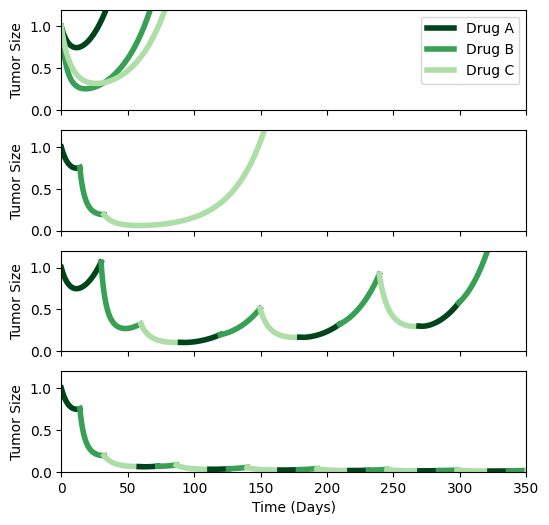

In [660]:
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.08, 0.1, 0.05]
gamma0_vals = [0.1, 0.25, 0.15]
resensitisation_rates = [0.01, 0.001, 0.08]



fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, lambda_vals, epsilon_vals, gamma0_vals=gamma0_vals, prog_size=2) 
    
dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols_sens, lambda_vals, epsilon_vals,
                                        gamma0_vals=gamma0_vals, prog_size=1.2, plot_nadir=False)

    
weekly_df = plot_treatment_cycle(ax=axs[2], drug_duration=[30]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=lambda_vals,
                                 epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                 resensitisation_rates=resensitisation_rates, n=None)

monthly_df = plot_treatment_cycle(ax=axs[3], drug_duration=None, seq=[0,1,2],
                                   cols=cols_sens, lambda_vals=lambda_vals,
                                   epsilon_vals=epsilon_vals, gamma0_vals=gamma0_vals,
                                   resensitisation_rates=resensitisation_rates, n=None) 

axs[1].get_legend().remove(); axs[2].get_legend().remove(); axs[3].get_legend().remove()
axs[0].set_xlim(0, 350)
axs[0].set_ylim(0, 1.2 * V0)
axs[0].set_xlabel(''); axs[1].set_xlabel(''); axs[2].set_xlabel(''); 

compare_df(weekly_df, monthly_df)
plt.savefig('images/nadir_switching.png')


## Combination therapy trial

In [404]:
# Combination therapy - single drug fits

clin_lambda_vals = [0.0428, 0.0428, 0.0428]
clin_epsilon_vals = [0.0137, 0.0096, 0.001]
clin_gamma0_vals = [0.203, 0.214, 0.199]

lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.01, 0.02, 0.05]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_ivp/radau.py:570: RuntimeWarning: overflow encountered in add
  y += self.y_old[:, None]
/Users/80024651/Documents/Moffitt/Workshop/treatment-sequencing/treatment_sequencing/growthInhibitionModel.py:19: RuntimeWarning: invalid value encountered in scalar subtract
  state_change[0] = self.params['lambda'] * V - gamma * V
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:348: RuntimeWarning: overflow encountered in multiply
  update = max_diff[ind] * scale_new < max_diff_new * scale[ind]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in divide
  diff /= h


ValueError: array must not contain infs or NaNs

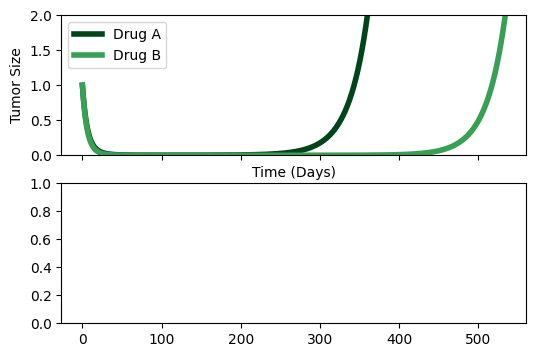

In [406]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

cols_sens = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols_sens):
    plot_drug_sequence(axs[0], [i], cols_sens, clin_lambda_vals, clin_epsilon_vals, gamma0_vals=clin_gamma0_vals, prog_thresh=2) 

    
weekly_df = plot_treatment_cycle(ax=axs[1], drug_duration=[7]*3, seq=[0,1,2], 
                                 cols=cols_sens, lambda_vals=clin_lambda_vals,
                                 epsilon_vals=clin_epsilon_vals, gamma0_vals=clin_gamma0_vals,
                                 resensitisation_rates=[0.000]*3, n=None)

axs[0].legend(['Sot + Afa', 'Sot + Tra', 'Sot + Pal'], loc=5)  
axs[0].get_legend().set_title("Combination\n  Therapies"); 
axs[1].get_legend().remove(); 
axs[0].set_xlim(0, max(max(weekly_df.Time), max(monthly_df.Time)))
axs[0].set_ylim(0, 1.2 * V0)
axs[1].set_yscale('log'); axs[1].set_ylim(0.01, 1)

compare_df(weekly_df, monthly_df)
plt.savefig('images/clinical_combination_therapies.png')